In [1]:
# Importing libraries
#If this is giving an error about scalebar, run: "pip install matplotlib-scalebar" in the terminal
import geopandas as gpd
import pyproj
from geocube.api.core import make_geocube
import requests
import geojson
import pandas as pd
import numpy as np

# Fetching data from WFS using requests, in json format, using bounding box over the helsinki area
#r = requests.get("""http://lipas.cc.jyu.fi/geoserver/lipas/ows?service=wfs&version=2.0.0&request=GetFeature&typeNames=lipas:lipas_3110_uimahalli&bbox=361500.0001438780454919,6665250.0001345984637737,403750.0001343561452813,6698000.0001281434670091,EPSG:3067&outputFormat=json""")

#fetching football stadiums to limit the number of used files
r = requests.get("""http://lipas.cc.jyu.fi/geoserver/lipas/ows?service=wfs&version=2.0.0&request=GetFeature&typeNames=lipas:lipas_1350_jalkapallostadion&bbox=361500.0001438780454919,6665250.0001345984637737,403750.0001343561452813,6698000.0001281434670091,EPSG:3067&outputFormat=json""")

# Creating GeoDataFrame from geojson
data = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

# Removing unnecessary attributes from lipas_data
lipas_data = data[["geometry","id","nimi_fi","nimi_se","tyyppikoodi","tyyppi_nimi_fi"]]

## Creating a list of YKR_IDs based on the location of sport facilities

# Set filepath for YKR grid and read the data
ykr_fp = r"data/MetropAccess_YKR_grid_EurefFIN.shp"
ykr_grid = gpd.read_file(ykr_fp)

# Defining crs for lipas_data (ykr_grid is already set)
lipas_data.crs = {'init':'epsg:3067'}
ykr_grid.crs = {'init':'epsg:3067'}

# Executing a spatial join to find out YKR-grid cells that have a sport facility inside them
lipas_join = gpd.sjoin(lipas_data, ykr_grid, how="inner", op="within")

# Collecting unique YKR_IDs into a list
ykr_list = lipas_join['YKR_ID'].unique().tolist()

#formulates the filepaths to match folder structure and puts them to list
    
    #create a list for the outputs
fps = []
    
    #loop over the inputs and keep track of loops
for num, i in enumerate(ykr_list):

    #access the first 4 numbers of the input which indicate the folder name (xxx added in the string)
    folder = str(i)[0:4]

    #put together the filepath according to the filepaths when you unzip Travel Time Matrix
    fp = r"data/HelsinkiTravelTimeMatrix2018/" + folder + "xxx/travel_times_to_ " + str(i) + ".txt"
    #Print which file is under process and how many in total
    print("Processing file " + fp + ". Progress: " + str(num+1) + "/" + str(len(ykr_list)))

    #add the filepath to filepaths list
    fps.append(fp)
    

#Joins YKR grid with chosen files from Travel Time Matrix. Travel times recorded from first file by bike like "bike_f_t_0"
#Minimum travel time to closest destination by bike recorded as "min_t_bike"

#access the YKR grid to get the spatial extent and geometry (has to be saved in data folder)
fpgrid = "data/MetropAccess_YKR_grid_EurefFIN.shp"
grid = gpd.read_file(fpgrid)

#iterate over filepaths
for i, fp in enumerate(fps):

    #read in the file
    data = pd.read_csv(fp, sep=";", usecols=["from_id", "bike_f_t", "pt_r_t", "car_r_t"])
    #get the cell number
    cell_ID = fp.split("_")[-1][:-4]
    #create new names for each added columns by the number of the file under processing (i)
    new_names = {"from_id": "YKR_ID", "bike_f_t": "bike_f_t_" + str(i), "pt_r_t": "pt_r_t_" + str(i),
                "car_r_t": "car_r_t_" + str(i)}
    data= data.rename(columns=new_names)

    #merge file with grid on the id of cells and remove no data values
    grid = grid.merge(data, on="YKR_ID")
    grid.replace(to_replace=-1, value=np.nan, inplace=True)
    grid = grid.dropna()

#initialise empty columns for minimum travel times
grid["min_t_bike"] = None
grid["min_t_car"] = None
grid["min_t_pt"] = None


#if there are multiple destination points, count the minimum travel time to closest destination point
if(len(fps)>1):

    #first assign all columns starting with "bike" to variable bike_cols (with list comprehension)
    bike_cols = [col for col in grid if col.startswith("bike")]
    #apply minimum function to those columns and save the value to min column. Repeat for others.
    grid["min_t_bike"] = grid[bike_cols].apply(min, axis=1)

    car_cols = [col for col in grid if col.startswith("car")]
    grid["min_t_car"] = grid[car_cols].apply(min, axis=1)

    pt_cols = [col for col in grid if col.startswith("pt")]
    grid["min_t_pt"] = grid[pt_cols].apply(min, axis=1)

geodata = grid

geodata.head()

Processing file data/HelsinkiTravelTimeMatrix2018/5936xxx/travel_times_to_ 5936682.txt. Progress: 1/4
Processing file data/HelsinkiTravelTimeMatrix2018/5967xxx/travel_times_to_ 5967140.txt. Progress: 2/4
Processing file data/HelsinkiTravelTimeMatrix2018/5961xxx/travel_times_to_ 5961882.txt. Progress: 3/4
Processing file data/HelsinkiTravelTimeMatrix2018/5900xxx/travel_times_to_ 5900202.txt. Progress: 4/4


,x,y,YKR_ID,geometry,bike_f_t_0,pt_r_t_0,car_r_t_0,bike_f_t_1,pt_r_t_1,car_r_t_1,bike_f_t_2,pt_r_t_2,car_r_t_2,bike_f_t_3,pt_r_t_3,car_r_t_3,min_t_bike,min_t_car,min_t_pt
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",74.0,130.0,52.0,87.0,144,58.0,77.0,120,54.0,54.0,104,40.0,54.0,40.0,104.0
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",77.0,133.0,54.0,87.0,147,61.0,77.0,123,56.0,53.0,107,43.0,53.0,43.0,107.0
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",77.0,134.0,54.0,87.0,148,61.0,77.0,124,56.0,53.0,108,43.0,53.0,43.0,108.0
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",82.0,138.0,55.0,92.0,153,61.0,82.0,129,56.0,58.0,113,43.0,58.0,43.0,113.0
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",73.0,123.0,51.0,86.0,137,58.0,75.0,113,53.0,52.0,97,40.0,52.0,40.0,97.0


In [2]:
attr_list = ["bike_f_t_0","pt_r_t_0"]
cube = make_geocube(vector_data=geodata, measurements= attr_list, resolution=(250, -250))

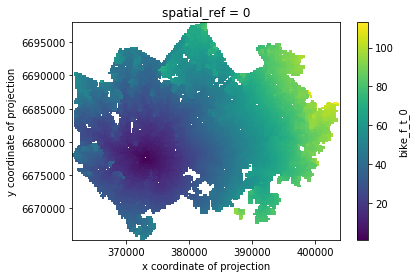

In [3]:
cube.bike_f_t_0.plot()

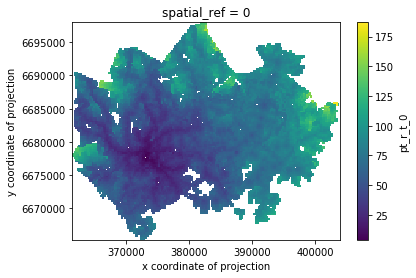

In [4]:
cube.pt_r_t_0.plot()

In [7]:
lipas_tyyppi ="1350"
lipas_laji= "jalkapallostadion"
cube.bike_f_t_0.rio.to_raster("outputs/"+lipas_tyyppi + "_"+lipas_laji+"_"+"bike_f_t_0.tif")